In [6]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import NullLocator
from statsmodels.stats.proportion import proportion_confint
import math
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "../figures/in_vitro_ASC"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc._settings.figdir = output_dir
output_suffix = ""
output_formats = [".png", ".pdf"]
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
sns.set_style("ticks")
plt.style.use('../scripts/bursa.mplstyle')
%run ../scripts/global_plot_settings.py

<Figure size 960x720 with 0 Axes>

# 

In [2]:
# get data from Swift et. al 2023
adata = sc.read_h5ad("../../data/gex/LSA2023.h5ad.gz")
adata.obs_names_make_unique(join="_")

In [3]:
# harmonize data with Cvijovic and Swift 2024 
bcell_data = adata.obs
bcell_data['bcelltype'] = bcell_data['celltypist']
# only use differntiation time points (exclude day 0)
bcell_data['in_vitro_stim'] = bcell_data['sample_id'].isin(["Day 4", "Day 8", "Day 12"])
# Combine "Plasmablasts" and "Plasma cells" into "ASC"
bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Plasmablasts', 'Plasma cells'], 'ASCs')
bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Proliferative germinal center B cells'], 'GC B cells')
bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Age-associated B cells'], 'ABCs')

/tmp/ipykernel_45500/3610291546.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Plasmablasts', 'Plasma cells'], 'ASCs')
/tmp/ipykernel_45500/3610291546.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Proliferative germinal center B cells'], 'GC B cells')
/tmp/ipykernel_45500/3610291546.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be 

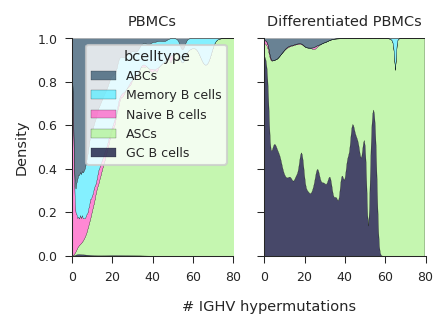

In [7]:
# Make Density Plots:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=(3,2))


g = sns.kdeplot(data=bcell_data[bcell_data.in_vitro_stim == True], x='v_mismatch', hue='bcelltype', palette=get_colors("bcelltype_alt"), multiple='fill', lw=0.1, edgecolor = 'k', ax = ax[1], legend=False)
g = sns.kdeplot(data=bcell_data[bcell_data.in_vitro_stim == False], x='v_mismatch', hue='bcelltype', palette=get_colors("bcelltype_alt"), multiple='fill', lw=0.1, edgecolor = 'k', ax = ax[0], legend=True)
sns.despine(fig)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xlim([0,80])
ax[0].set_xticks([0,20,40,60,80])
ax[0].set_title('PBMCs', fontsize=7)
ax[1].set_title('Differentiated PBMCs', fontsize=7)
fig.tight_layout()
fig.supxlabel('# IGHV hypermutations', fontsize=7, x = 0.6, y = -0.05)

In [8]:
# Prepare the data / bins
bcell_data = bcell_data[bcell_data.v_mismatch > 0]
bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 45, 50]
bcell_data['bin'] = pd.cut(bcell_data.v_mismatch, bins=bin_edges)
# Ensure 'v_mismatch' column is free of NaN values or fill them with a default integer value
bcell_data['v_mismatch'] = bcell_data['v_mismatch'].fillna(0) # or some other appropriate fill value

# Attempt to convert 'v_mismatch' to integers, catching any errors that may arise
try:
    bcell_data['v_mismatch'] = bcell_data['v_mismatch'].astype(int)
except ValueError as e:
    print(f"Conversion failed: {e}")
    # Optionally, inspect non-convertible entries
    non_ints = bcell_data['v_mismatch'][~bcell_data['v_mismatch'].apply(lambda x: x.is_integer())]
    print(non_ints)

/tmp/ipykernel_45500/4169530769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcell_data['bin'] = pd.cut(bcell_data.v_mismatch, bins=bin_edges)
/tmp/ipykernel_45500/4169530769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcell_data['v_mismatch'] = bcell_data['v_mismatch'].fillna(0) # or some other appropriate fill value
/tmp/ipykernel_45500/4169530769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [9]:
# Find the min and max of the v_mismatch data to determine the bin range
min_v_mismatch = bcell_data['v_mismatch'].min()
max_v_mismatch = bcell_data['v_mismatch'].max()

# Generate bins from the min to max with a step of 1 (integer bins)
bins = 17 # kind of arbitrary
bins = np.arange(0,45,5)
bcell_data['bin'] = pd.cut(bcell_data.v_mismatch, bins = bins, include_lowest=True)

/tmp/ipykernel_45500/2245474053.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcell_data['bin'] = pd.cut(bcell_data.v_mismatch, bins = bins, include_lowest=True)


/tmp/ipykernel_45500/455984399.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = bcell_data.groupby(['bin', 'in_vitro_stim'])
/tmp/ipykernel_45500/455984399.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fractions_per_sample = grouped.apply(lambda group: calculate_fraction_and_ci(group, celltype)).reset_index()
/tmp/ipykernel_45500/455984399.py:34: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matp

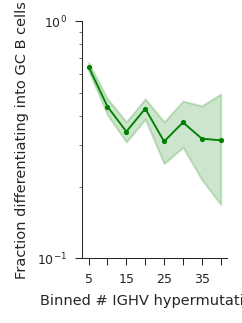

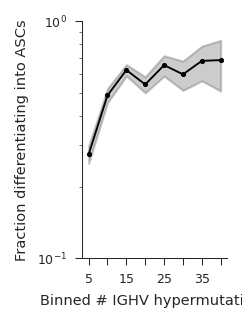

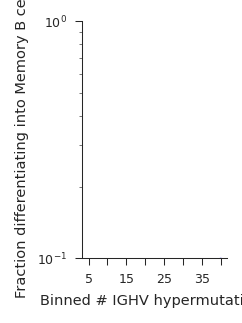

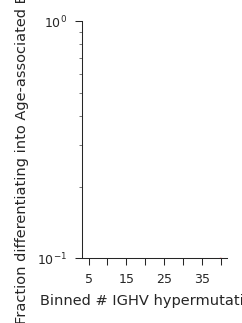

In [10]:
# function to calculate the fraction and confidence interval
def calculate_fraction_and_ci(group, celltype):
    count_celltype = (group['bcelltype'] == celltype).sum()
    n_total = len(group)
    fraction_celltype = count_celltype / n_total
    lower, upper = proportion_confint(count_celltype, n_total, alpha=0.05, method='beta')
    return pd.Series({f'fraction_{celltype}': fraction_celltype, 'lower_ci': lower, 'upper_ci': upper, 'total_cells_in_bin': n_total})

# List of cell types interested in
celltypes = ["GC B cells", "ASCs", "Memory B cells"]
# filter out bins that have very few cells
filter_bins = True
n_cells = 10
# Dictionary to store color information for each cell type
celltypes_dict = {
    "GC B cells": 'green',
    "ASCs": 'black',
    "Memory B cells": 'blue',
    "Age-associated B cells": 'red'
}


# just plot ASCs:
celltypes = ["ASCs"]

for celltype in celltypes:
    grouped = bcell_data.groupby(['bin', 'in_vitro_stim'])
    fractions_per_sample = grouped.apply(lambda group: calculate_fraction_and_ci(group, celltype)).reset_index()
    fractions_per_sample = fractions_per_sample[fractions_per_sample.in_vitro_stim == True]
    if filter_bins:
        fractions_per_sample = fractions_per_sample[fractions_per_sample['total_cells_in_bin'] >= n_cells]
    # Extract the right edge and round it to the nearest integer for labeling
    fractions_per_sample['bin_label'] = fractions_per_sample['bin'].apply(lambda x: str(int(math.floor(x.right))))
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(1.25, 2.05))
    points_plot = sns.pointplot(data=fractions_per_sample, x='bin_label', y=f'fraction_{celltype}', errorbar=None, color=celltypes_dict[celltype], join=True, scale = 0.5)
    
    # Manually adjust the size of the points to 0
    for point in points_plot.collections:
        point.set_sizes([2])
    ax.set_yscale('log')
    # Set y-axis minor ticks but disable minor tick labels
    ax.yaxis.set_minor_locator(plt.LogLocator(subs='auto'))
    ax.tick_params(axis='y', which='minor', length=1.5)
    ax.tick_params(axis='y', which='minor', labelleft=False)
    # Manually add the filled error bars using plt.fill_between
    x_values = range(len(fractions_per_sample))
    ax.fill_between(x_values, fractions_per_sample['lower_ci'], fractions_per_sample['upper_ci'], color=celltypes_dict[celltype], alpha=0.2)
        # Remove every other xticklabel
        # Remove every second xticklabel starting from the first
    for i, label in enumerate(ax.xaxis.get_ticklabels()):
        if i % 2 == 1:  # This will hide the second label, fourth label, and so on
            label.set_visible(False)
    ax.set_xlabel('Binned # IGHV hypermutations')
    ax.set_ylabel(f'Fraction differentiating \n into {celltype}')
    sns.despine()
    ax.set_ylim(0.1, 1)
    plt.gca().xaxis.set_minor_locator(NullLocator())
    save_figure(fig, f"v_mismatch_diff_chance_{celltype.replace(' ', '_')}")